In [ ]:
import mne
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy
import spkit as sp

# Read Zenodo data set

In [ ]:
mat=scipy.io.loadmat('../BraiNeoCare/Datasets/zenodo_eeg/annotations_2017.mat')

def signal_array(raw_data):
    ch1=raw_data[0]-raw_data[5]
    ch2=raw_data[5]-raw_data[7]
    ch3=raw_data[0]-raw_data[2]
    ch4=raw_data[2]-raw_data[7]
    ch5=raw_data[1]-raw_data[3]
    ch6=raw_data[3]-raw_data[8]
    ch7=raw_data[1]-raw_data[6]
    ch8=raw_data[6]-raw_data[8]
    ch9=raw_data[5]-raw_data[2]
    ch10=raw_data[2]-raw_data[4]
    ch11=raw_data[4]-raw_data[3]
    ch12=raw_data[3]-raw_data[6]
    return np.array([ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12])

def find_seizure_time(file_no):
    b=mat['annotat_new'][0][file_no-1][0] & mat['annotat_new'][0][file_no-1][1] & mat['annotat_new'][0][file_no-1][2]
    a=np.where(b==1)[0]
    s_time=[]
    e_time=[]
    if len(a)!=0:
        s_time.append(a[0])  
        for r in range(1,a.shape[0]):
            if a[r-1]-a[r]!=-1:
                e_time.append(a[r-1]+1)
                s_time.append(a[r]) 
        e_time.append(a[-1]+1)  
        
    return np.array(s_time),np.array(e_time)

### Signal filtering and downsampling

In [56]:
fs=256
fs_d=32
order=7
resampling_factor=fs_d/fs

l_cut=16
h_cut=0.5

b_low,a_low=scipy.signal.butter(order,l_cut,'low',fs=fs)
b_high,a_high=scipy.signal.butter(order,h_cut,'high',fs=fs)

def bandpassFilter(signal1):
    lowpasss=scipy.signal.filtfilt(b_low,a_low,signal1,axis=1)
    return scipy.signal.filtfilt(b_high,a_high,lowpasss,axis=1)

def downsample(signal1):
    filter_signal=bandpassFilter(signal1)
    new_n_samples=int(signal1.shape[1]*resampling_factor)
    return scipy.signal.resample(filter_signal,new_n_samples,axis=1)

def check_consecutive_zeros(arr):
    zeros = arr == 0
    consecutive_zeros = np.convolve(zeros[0], np.ones(32))
    return any(consecutive_zeros >= 32)

def removeArtifacts(signal1):
    beta_val=0.3
    # mu=np.array([np.mean(signal1,axis=1)]).T
    # std=np.array([np.std(signal1,axis=1)]).T
    # signal1=(signal1-mu)/std
    signal1=bandpassFilter(signal1)
    signal1=scipy.signal.resample_poly(signal1,up=128,down=256,axis=1)
    signal1=signal1*3000000
    clean_array= sp.eeg.ATAR(signal1.T, wv='db3', winsize=128, beta=beta_val, thr_method='ipr', OptMode='soft',verbose=0)
    #clean_array=sp.eeg.ICA_filtering(signal1.T,verbose=0,kur_thr=2,corr_thr=0.8,winsize=128)
    clean_array=clean_array.T/3000000
    signal1=scipy.signal.resample_poly(clean_array,up=32,down=128,axis=1)

    return signal1

### Data visualization

In [57]:
n=9
file=f'../BraiNeoCare/Datasets/zenodo_eeg/eeg{n}.edf'
data = mne.io.read_raw_edf(file)
try:
    data=data.pick_channels(['EEG Fp1-Ref', 'EEG Fp2-Ref', 'EEG C3-Ref', 'EEG C4-Ref', 
                             'EEG Cz-Ref', 'EEG T3-Ref', 'EEG T4-Ref', 'EEG O1-Ref', 'EEG O2-Ref'],ordered=True)
    raw_data=data.get_data()
    signal=signal_array(raw_data)
except:
    data=data.pick_channels(['EEG Fp1-REF', 'EEG Fp2-REF', 'EEG C3-REF', 'EEG C4-REF', 
                             'EEG Cz-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG O1-REF', 'EEG O2-REF'],ordered=True)
    raw_data=data.get_data()
    signal=signal_array(raw_data)
channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]

# signal1=downsample(signal1)
signal1=removeArtifacts(signal)

signal=downsample(signal)

s_Time,e_Time=find_seizure_time(n) 
seizures=np.zeros((12,len(signal[0])))

for i in range(12):
    for r in range(len(s_Time)):
        seizures[i,s_Time[r]*32:e_Time[r]*32]=signal[i,s_Time[r]*32:e_Time[r]*32]

Extracting EDF parameters from /home/nima/BraiNeoCare/Datasets/zenodo_eeg/eeg9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


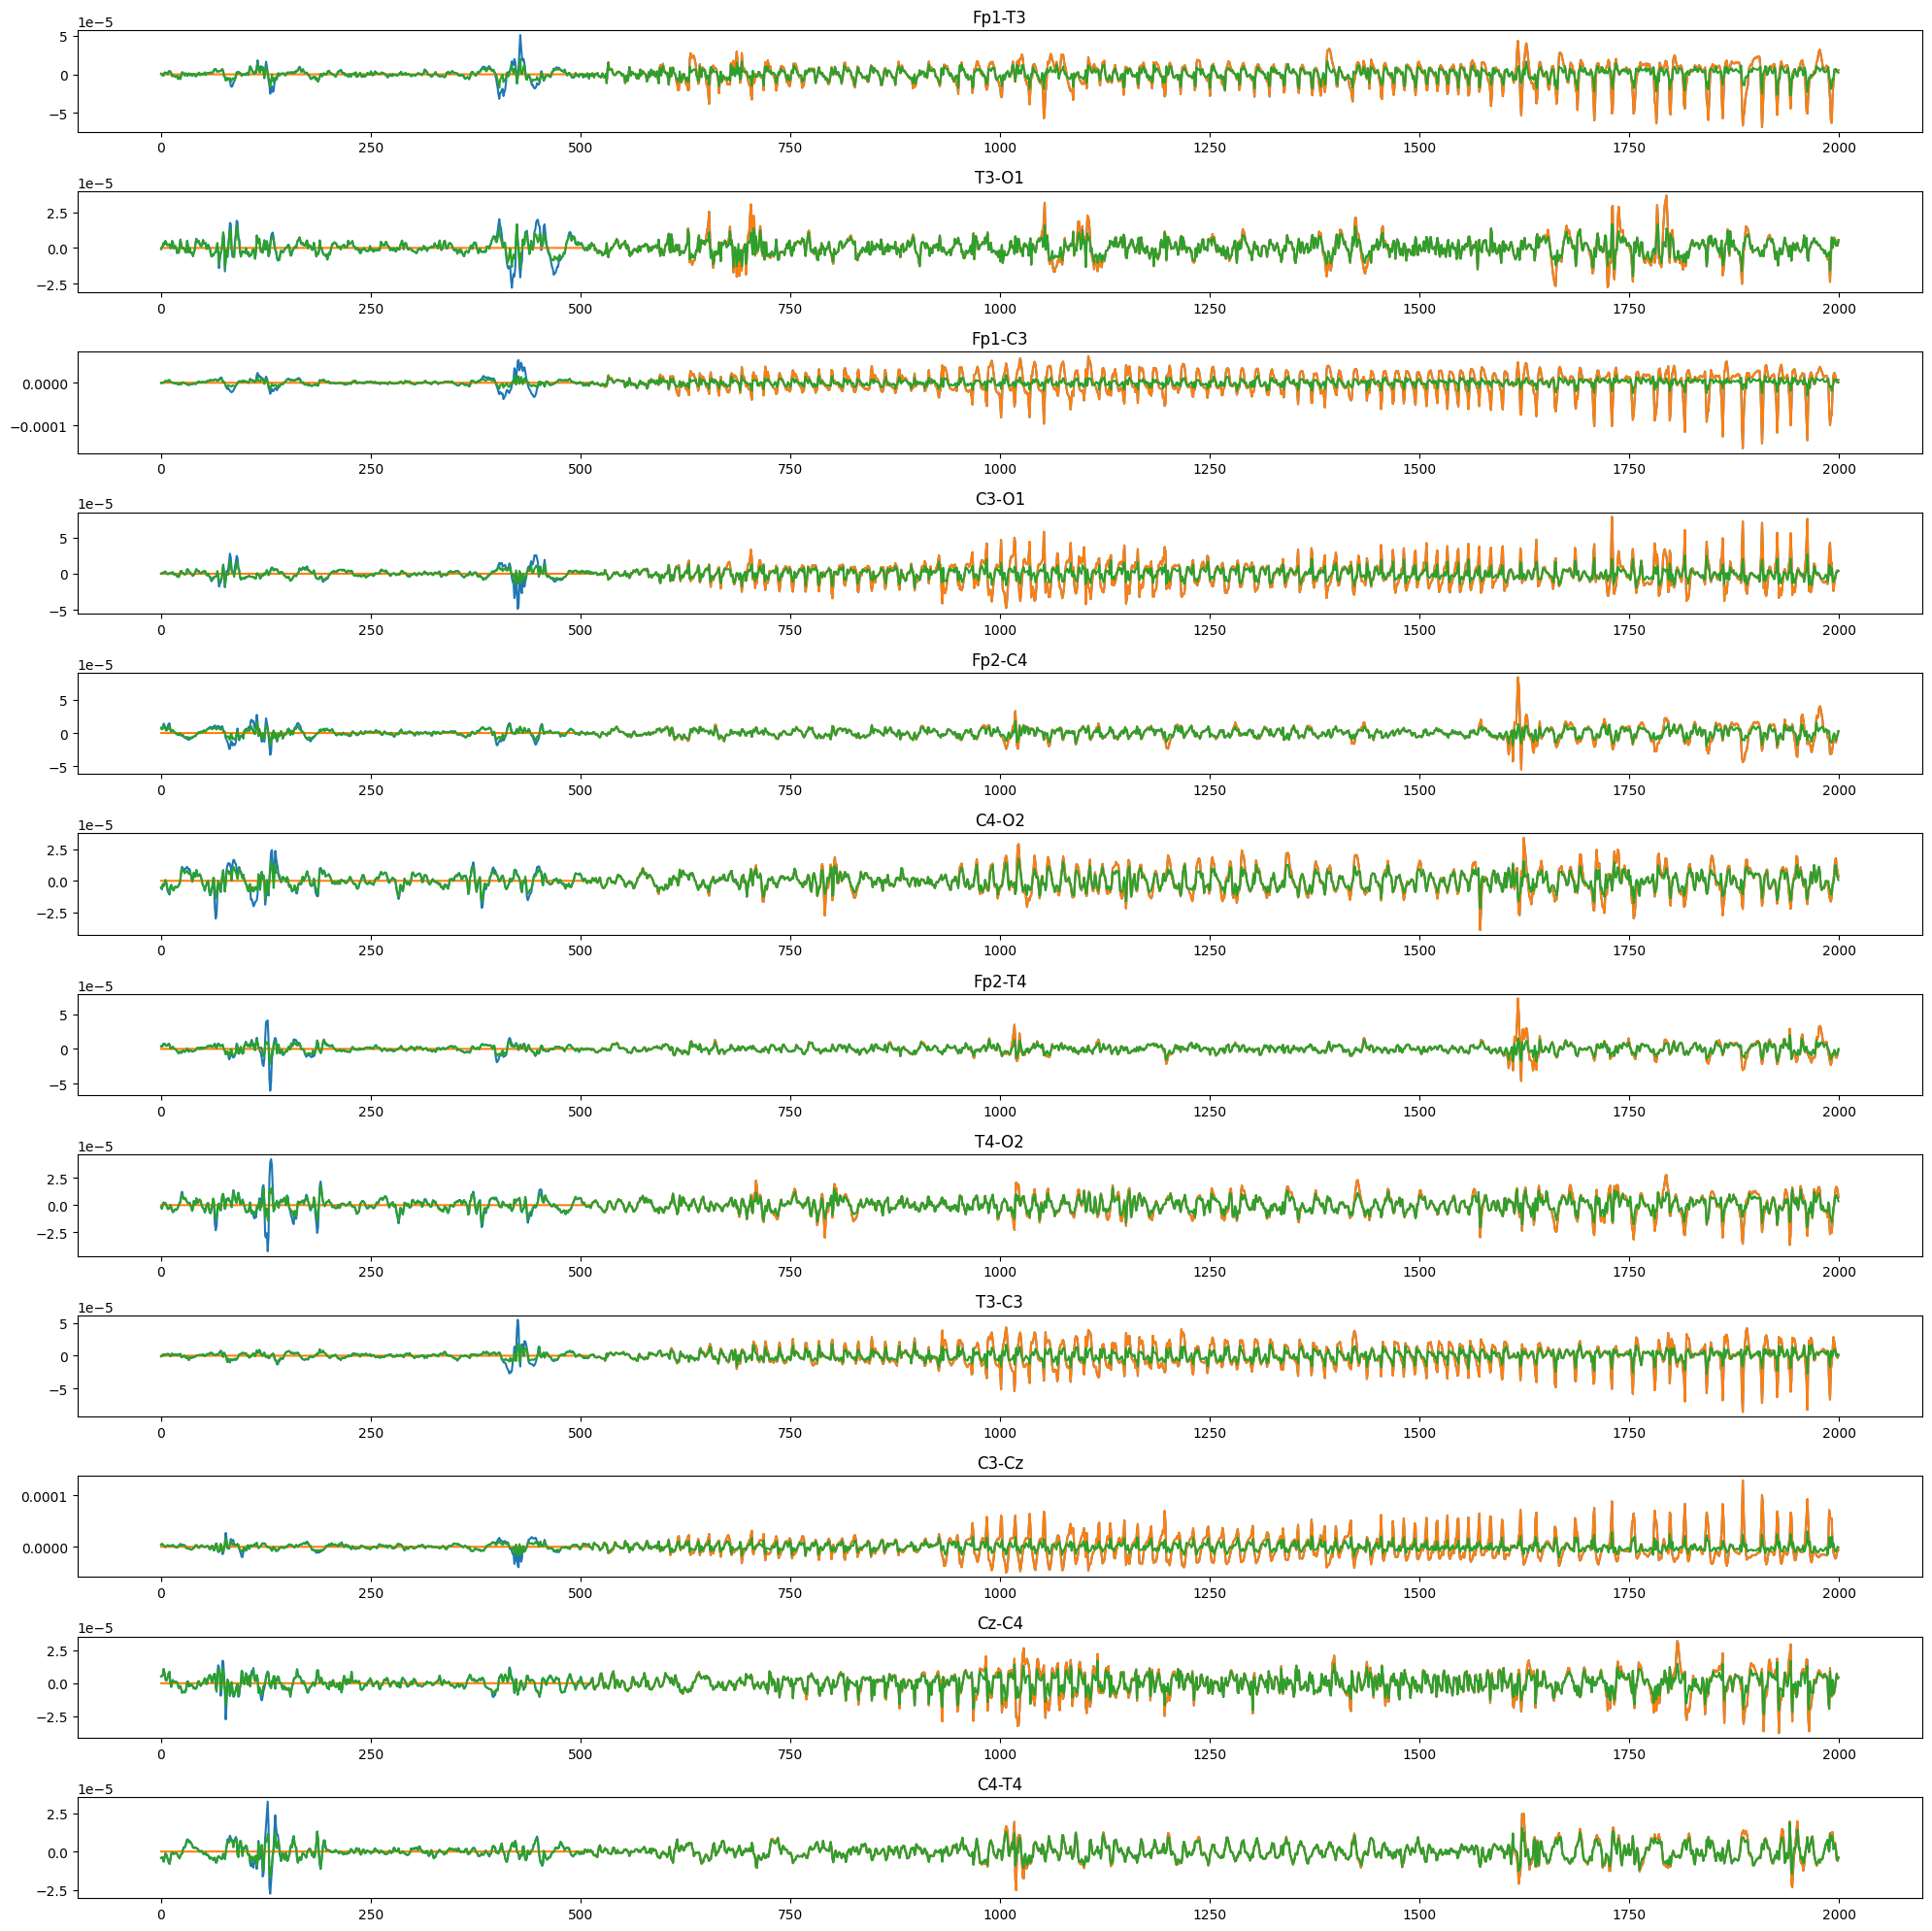

In [58]:
# signal1=downsample(signal1)
fig,ax=plt.subplots(12,1,figsize=(20,20))

for r in range(12):
    ax[r].plot(signal[r][8000:10000])
    ax[r].plot(seizures[r][8000:10000])
    ax[r].plot(signal1[r][8000:10000])
    ax[r].set_title(channel_names[r])
fig.tight_layout()
plt.show() 

### Data saving

In [ ]:
folder='../BraiNeoCare/Datasets/zenodo_eeg/'
signals=[]
seizure=[]
files=os.listdir(folder)    

for file in files:
    if file.endswith('.edf'):

        s_Time,e_Time=find_seizure_time(int(file.split('.')[0][3:])) 
        if (len(s_Time)!=0 ):
            data = mne.io.read_raw_edf(folder+file,verbose=False)
            try:
                data=data.pick_channels(['EEG Fp1-Ref', 'EEG Fp2-Ref',  'EEG C3-Ref', 'EEG C4-Ref', 'EEG Cz-Ref', 'EEG T3-Ref', 'EEG T4-Ref', 'EEG O1-Ref', 'EEG O2-Ref'],ordered=True)
                raw_data=data.get_data()
                signal=signal_array(raw_data)
            except:
                data=data.pick_channels(['EEG Fp1-REF', 'EEG Fp2-REF', 'EEG C3-REF','EEG C4-REF', 'EEG Cz-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG O1-REF', 'EEG O2-REF'],ordered=True)
                raw_data=data.get_data()
                signal=signal_array(raw_data)
            
            signal_partition=0
            started=False

            while signal_partition*1024<raw_data.shape[1]:

                u_bound=(signal_partition+1)*1024
                l_bound=signal_partition*1024
                partition=signal[:,l_bound:u_bound]

                if partition.shape[1]==1024:
                    signals.append(partition)
                        
                    if np.any((s_Time*256>=l_bound) & (s_Time*256<=u_bound-1)):
                        seizure.append(1)
                        started=True

                    elif np.any((l_bound<(e_Time*256-1)) & ((e_Time*256-1)<=(u_bound-1))):
                        seizure.append(1)
                        started=False

                    elif (started and np.any((e_Time*256-1)>u_bound-1)):
                        seizure.append(1)
                    else:
                        seizure.append(0)
                    # else:
                    #     seizure.append(0)
        
                signal_partition+=1

signals=np.array(signals)
seizure=np.array(seizure)
np.save('../BraiNeoCare/Datasets/zenodo_data_consensus_4s.npy',signals)
np.save('../BraiNeoCare/Datasets/zenodo_labels_consensus_4s.npy',seizure)

In [ ]:
folder='../BraiNeoCare/Datasets/zenodo_eeg/'
train_signals=[]
train_seizure=[]
test_signals=[]
test_seizure=[]

files=os.listdir(folder)    
c=1
for file in files:
    if file.endswith('.edf'):
        
        s_Time,e_Time=find_seizure_time(int(file.split('.')[0][3:])) 

        if (len(s_Time)!=0 ):
            data = mne.io.read_raw_edf(folder+file,verbose=False)
            try:
                data=data.pick_channels(['EEG Fp1-Ref', 'EEG Fp2-Ref',  'EEG C3-Ref', 'EEG C4-Ref', 'EEG Cz-Ref', 'EEG T3-Ref',
                                        'EEG T4-Ref', 'EEG O1-Ref', 'EEG O2-Ref'],ordered=True)
                raw_data=data.get_data()
                signal=signal_array(raw_data)
            except:
                data=data.pick_channels(['EEG Fp1-REF', 'EEG Fp2-REF', 'EEG C3-REF','EEG C4-REF', 'EEG Cz-REF', 'EEG T3-REF', 
                                        'EEG T4-REF', 'EEG O1-REF', 'EEG O2-REF'],ordered=True)
                raw_data=data.get_data()
                signal=signal_array(raw_data)
            
            # signal=removeArtifacts(signal)
            signal=downsample(signal)
            u_bound=384
            l_bound=0
            started=False

            while u_bound<signal.shape[1]:
                
                partition=signal[:,l_bound:u_bound]

                if np.any((s_Time*32>=l_bound) & (s_Time*32<=u_bound-1)):
                    if c<=8:
                        test_signals.append(partition)
                        test_seizure.append(1)
                    else:
                        train_signals.append(partition)
                        train_seizure.append(1)
                    
                    started=True
                    u_bound+=32
                    l_bound+=32

                elif np.any((l_bound<(e_Time*32-1)) & ((e_Time*32-1)<=(u_bound-1))):
                    if c<=8:
                        test_signals.append(partition)
                        test_seizure.append(1)
                    else:
                        train_signals.append(partition)
                        train_seizure.append(1)
                    started=False
                    u_bound+=32
                    l_bound+=32

                elif (started and np.any((e_Time*32-1)>u_bound-1)):
                    if c<=8:
                        test_signals.append(partition)
                        test_seizure.append(1)
                    else:
                        train_signals.append(partition)
                        train_seizure.append(1)
                    u_bound+=32
                    l_bound+=32
                else:
                    if check_consecutive_zeros(partition):
                        pass
                    else:
                        if c<=8:
                            test_signals.append(partition)
                            test_seizure.append(0)
                        else:
                            train_signals.append(partition)
                            train_seizure.append(0)
                        u_bound+=64
                        l_bound+=64
            c+=1

test_signals=np.array(test_signals)
test_seizure=np.array(test_seizure)
train_signals=np.array(train_signals)
train_seizure=np.array(train_seizure)

np.save('../BraiNeoCare/Datasets/GAT/testdata.npy',test_signals)
np.save('../BraiNeoCare/Datasets/GAT/testlabels.npy',test_seizure)
np.save('../BraiNeoCare/Datasets/GAT/traindata.npy',train_signals)
np.save('../BraiNeoCare/Datasets/GAT/trainlabels.npy',train_seizure)

In [ ]:
train_signals.shape,test_signals.shape,train_seizure.sum(),test_seizure.sum()   

In [ ]:
# from sklearn.model_selection import train_test_split
# # x=np.load('../BraiNeoCare/Datasets/zenodo_data_consensus_4s.npy', mmap_mode='r')
# # y=np.load('../BraiNeoCare/Datasets/zenodo_labels_consensus_4s.npy', mmap_mode='r')

# x_train, x_test, y_train, y_test = train_test_split(signals, seizure, test_size=0.2, random_state=42)

In [ ]:
# y_train_positive_pos=np.where(y_train==1)
# y_test_positive_pos=np.where(y_test==1)

# x_train_positive=x_train[y_train_positive_pos]
# x_test_positive=x_test[y_test_positive_pos]

# y_train_negative_pos=np.where(y_train==0)
# y_test_negative_pos=np.where(y_test==0)

# x_train_negative=x_train[y_train_negative_pos][0:x_train_positive.shape[0],...]
# x_test_negative=x_test[y_test_negative_pos][0:x_test_positive.shape[0],...]

# new_x_train=np.concatenate((x_train_positive,x_train_negative),axis=0)
# new_y_train=np.concatenate((np.ones((x_train_positive.shape[0],)),np.zeros((x_train_negative.shape[0],))),axis=0)

# new_x_test=np.concatenate((x_test_positive,x_test_negative),axis=0)
# new_y_test=np.concatenate((np.ones((x_test_positive.shape[0],)),np.zeros((x_test_negative.shape[0],))),axis=0)

# np.save('../BraiNeoCare/Datasets/balanced_x_train_consensus_4s.npy',new_x_train)
# np.save('../BraiNeoCare/Datasets/balanced_y_train_consensus_4s.npy',new_y_train)

# np.save('../BraiNeoCare/Datasets/balanced_x_test_consensus_4s.npy',new_x_test)
# np.save('../BraiNeoCare/Datasets/balanced_y_test_consensus_4s.npy',new_y_test)

# Read chb-mit dataset 

In [ ]:
# seizure_files=[]
# folder='../ML_codes/chb01/'
# for file in os.listdir(folder):
#     if file.endswith(".seizures"):
#         seizure_files.append(file.split('.')[0])
# print(seizure_files)

In [ ]:
# def open_annotations(file,name):
#     f=open(file,'r')
#     lines_list=[]
#     for lines in f:
#        lines_list.append(lines.strip())
#     # print(lines_list)
#     index_of_file=lines_list.index("File Name: "+name+".edf")
#     start=int(lines_list[index_of_file+4].split(" ")[-2])
#     end=int(lines_list[index_of_file+4+1].split(" ")[-2])
#     return start,end

In [ ]:
# signals=[]
# seizure=[]
# summary_file='../ML_codes/chb01/chb01-summary.txt'
# start, end= 0, 0

# for file in os.listdir(folder):
#     if file.split('.')[-1]=='edf':       
#         data = mne.io.read_raw_edf(folder+file)
#         data=data.pick_channels(['FP1-F7','P7-O1','F3-C3','C3-P3','FP2-F8','P8-O2','F4-C4','C4-P4','FZ-CZ','CZ-PZ'])
#         raw_data=data.get_data()
        
#         if file.split('.')[0] in seizure_files:
#             start,end=open_annotations(summary_file,file.split('.')[0])

#         signal_partition=0
#         started=False

#         while signal_partition*1024<raw_data.shape[1]:

#             u_bound=(signal_partition+1)*1024
#             l_bound=signal_partition*1024
#             partition=raw_data[:,l_bound:u_bound]

#             if partition.shape[1]==1024:
#                 signals.append(partition)

#                 if (start!=0 and end!=0):
#                     if ((start*256>=l_bound) and (start*256<=u_bound-1)):
#                         seizure.append(1)
#                         started=True
#                     elif ((l_bound<(end*256-1)) and ((end*256-1)<=(u_bound-1))):
#                         seizure.append(1)
#                         started=False
#                     elif (started and ((end*256-1)>u_bound-1)):
#                         seizure.append(1)
#                     else:
#                         seizure.append(0)
#                 else:
#                     seizure.append(0)
        
#             signal_partition+=1

# signals=np.array(signals)
# seizure=np.array(seizure)
# np.save('chb001_data',signals)
# np.save('chb001_labels',seizure)